In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df=pd.read_csv("EV_cars.csv")

In [3]:
df.head(4)

,Battery,Car_name,Car_name_link,Efficiency,Fast_charge,Price.DE.,Range,Top_speed,acceleration..0.100.
0,75.0,Tesla Model Y Long Range Dual Motor,https://ev-database.org/car/1619/Tesla-Model-Y...,172,670.0,59017.0,435,217,5.0
1,57.5,Tesla Model 3,https://ev-database.org/car/1991/Tesla-Model-3,137,700.0,46220.0,420,201,6.1
2,60.5,BYD ATTO 3,https://ev-database.org/car/1782/BYD-ATTO-3,183,370.0,44625.0,330,160,7.3
3,61.7,MG MG4 Electric 64 kWh,https://ev-database.org/car/1708/MG-MG4-Electr...,171,630.0,39990.0,360,160,7.9


In [4]:
df.drop(columns=['Car_name','Car_name_link'],inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Battery               360 non-null    float64
 1   Efficiency            360 non-null    int64  
 2   Fast_charge           358 non-null    float64
 3   Price.DE.             309 non-null    float64
 4   Range                 360 non-null    int64  
 5   Top_speed             360 non-null    int64  
 6   acceleration..0.100.  360 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 19.8 KB


In [6]:
df.describe()

,Battery,Efficiency,Fast_charge,Price.DE.,Range,Top_speed,acceleration..0.100.
count,360.000000,360.000000,358.000000,309.000000,360.000000,360.000000,360.000000
mean,71.187500,195.175000,552.960894,67264.284790,369.694444,180.919444,7.288889
std,20.389849,31.909429,236.864801,34508.249544,107.315514,36.232023,3.005897
min,21.300000,137.000000,170.000000,22550.000000,135.000000,125.000000,2.100000
25%,57.500000,171.000000,360.000000,45690.000000,295.000000,155.750000,4.900000
50%,71.000000,188.000000,520.000000,56942.000000,380.000000,180.000000,6.750000
75%,85.000000,208.250000,680.000000,73100.000000,446.250000,200.000000,9.000000
max,123.000000,295.000000,1290.000000,218000.000000,685.000000,320.000000,19.100000


In [7]:
df.isna().sum()

Battery                  0
Efficiency               0
Fast_charge              2
Price.DE.               51
Range                    0
Top_speed                0
acceleration..0.100.     0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.isna().sum()

Battery                 0
Efficiency              0
Fast_charge             0
Price.DE.               0
Range                   0
Top_speed               0
acceleration..0.100.    0
dtype: int64

In [10]:
df.shape

(307, 7)

In [11]:
df.columns

Index(['Battery', 'Efficiency', 'Fast_charge', 'Price.DE.', 'Range',
       'Top_speed', 'acceleration..0.100.'],
      dtype='object')

In [12]:
cols=['Battery', 'Efficiency', 'Fast_charge', 'Price.DE.', 'Range',
       'Top_speed', 'acceleration..0.100.']

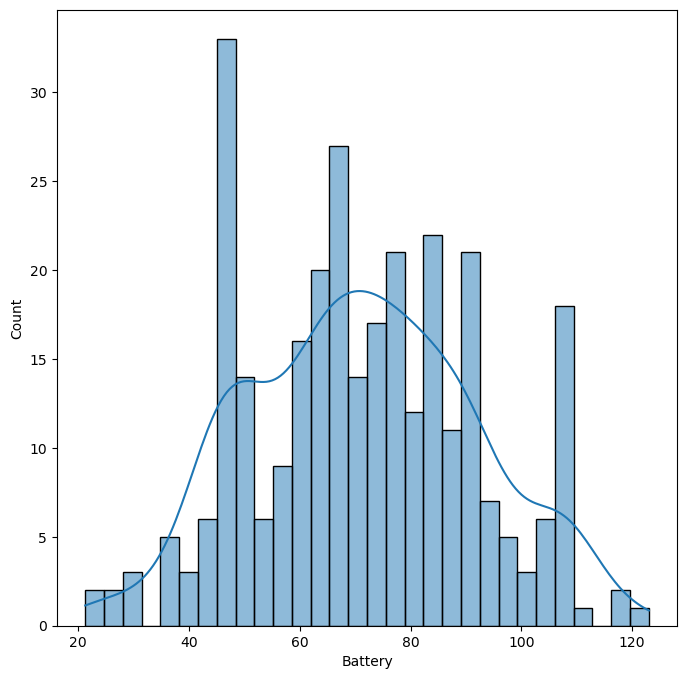

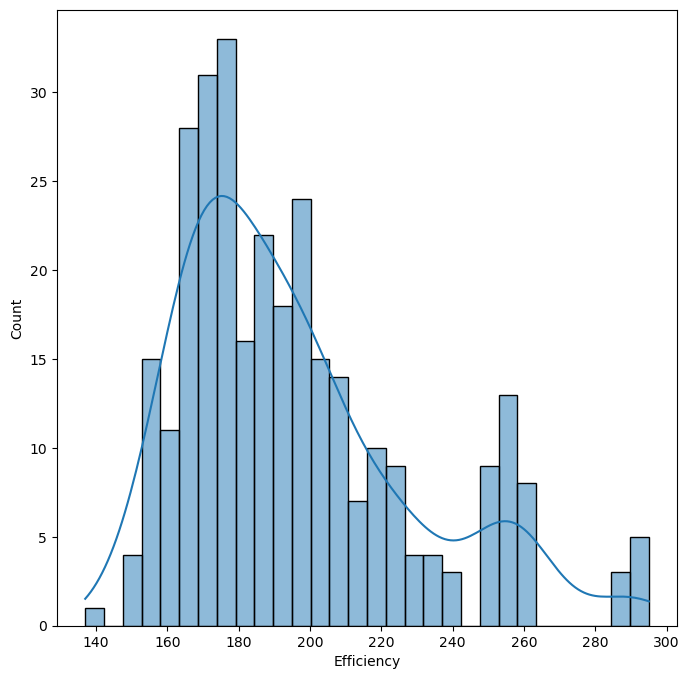

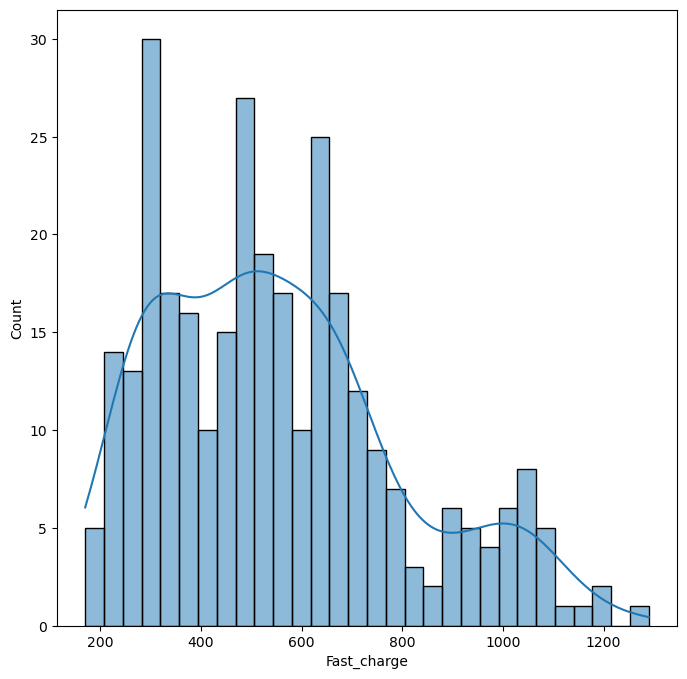

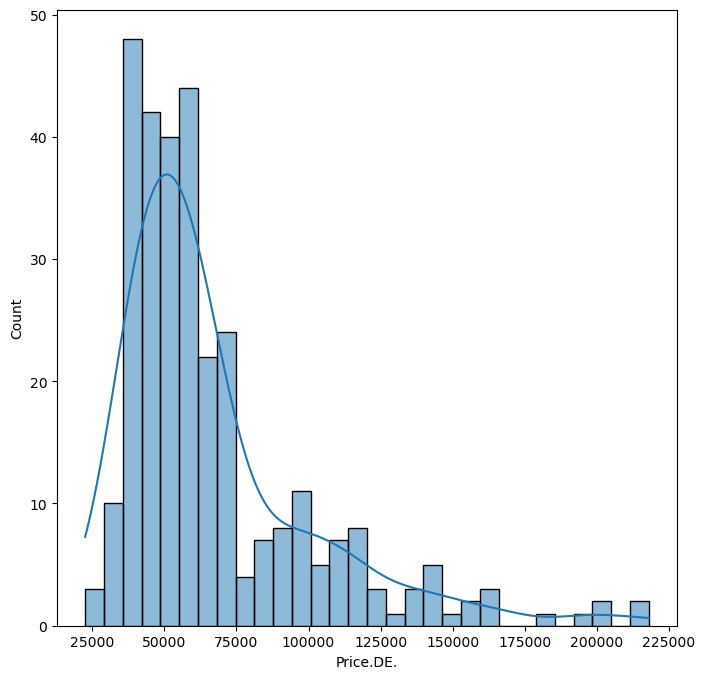

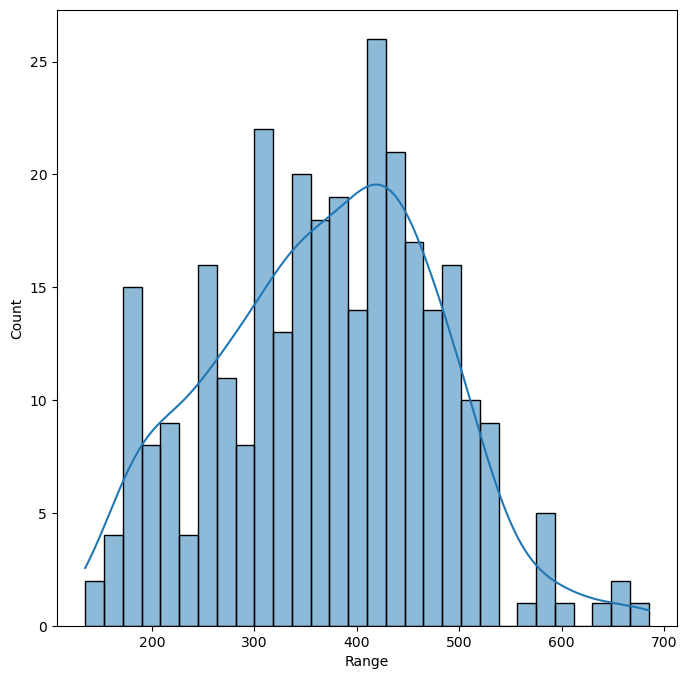

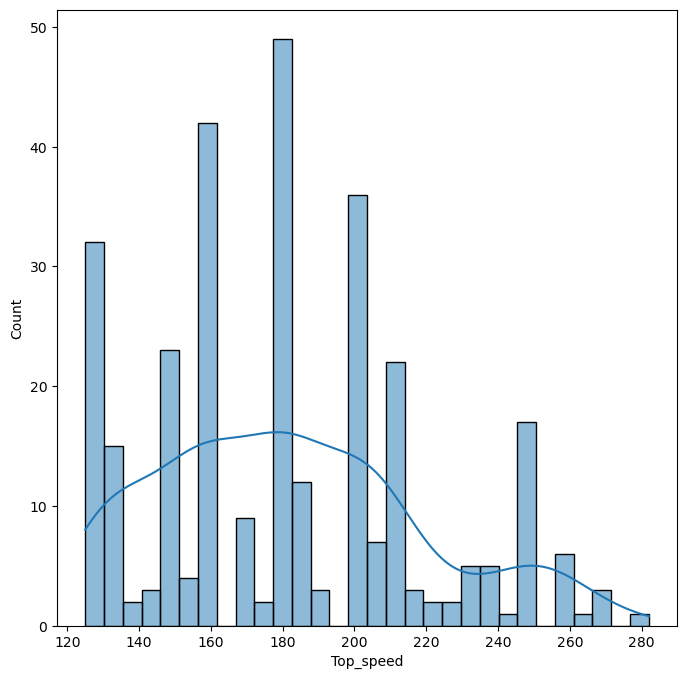

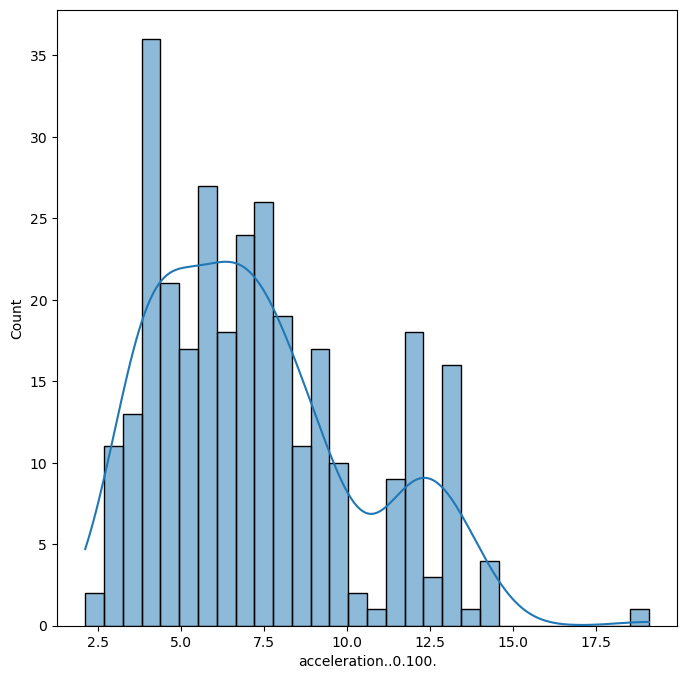

In [13]:
for col in cols:
    plt.figure(figsize=(8,8))
    sns.histplot(df[col],bins=30,kde=True)

In [14]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Create a mask (True = not outlier)
mask = pd.Series(True, index=df.index)

# Compute IQR bounds for each column
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Keep only non-outliers
    mask &= df[col].between(lower_bound, upper_bound)

# Apply the mask once (prevents progressive shrinking)
df_clean = df[mask].reset_index(drop=True)

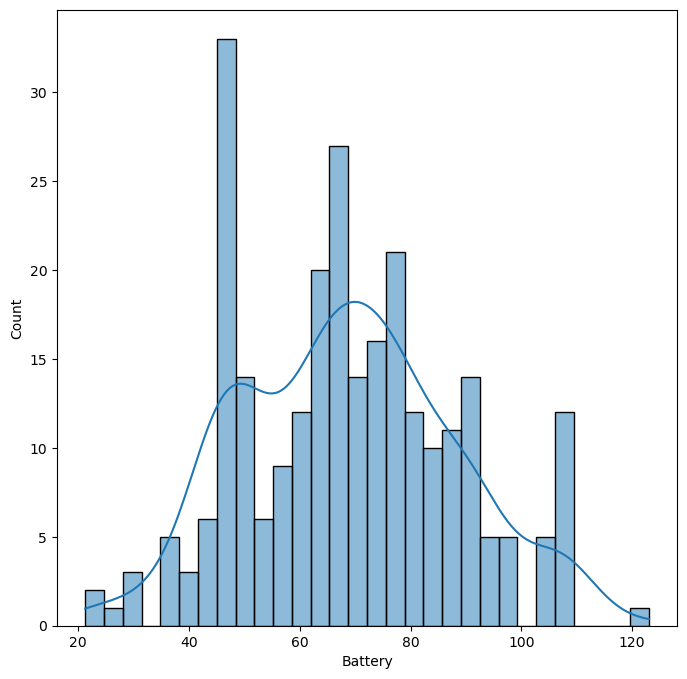

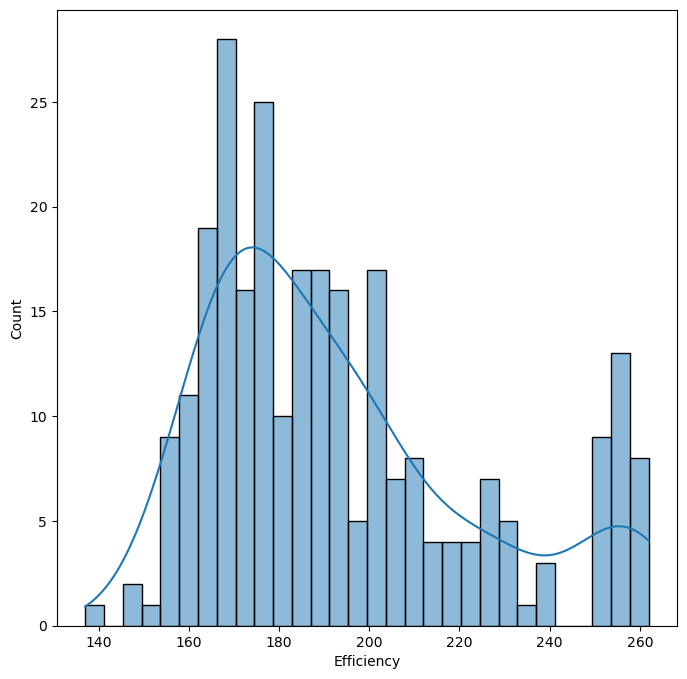

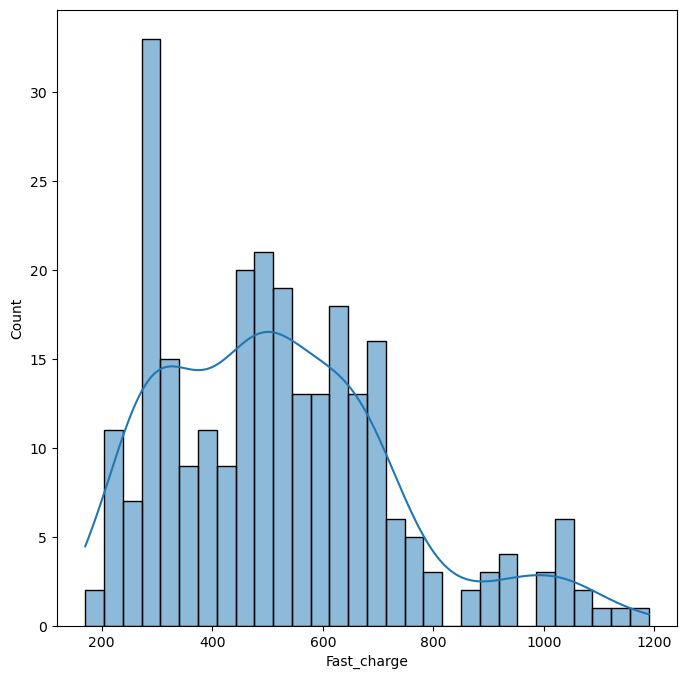

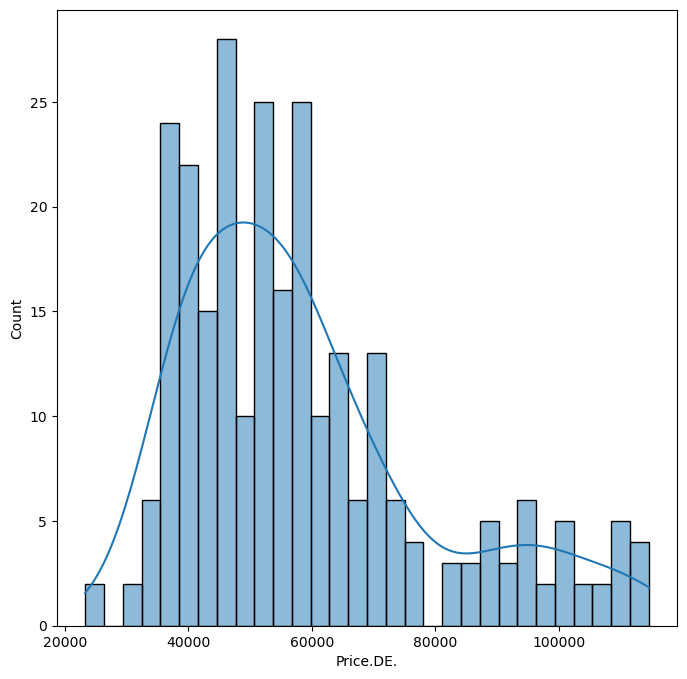

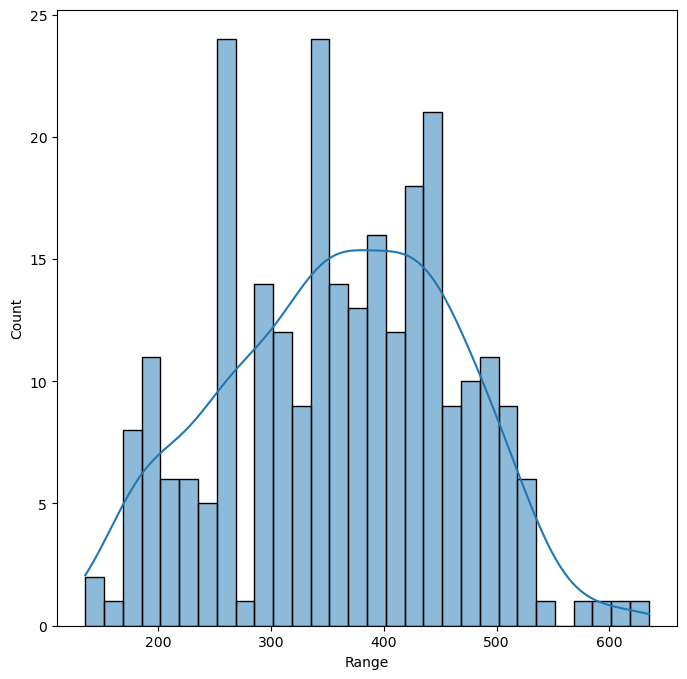

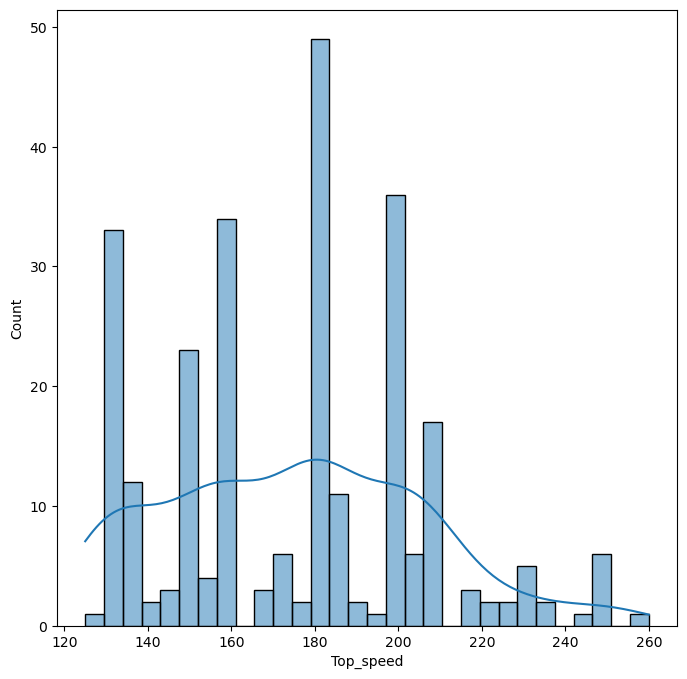

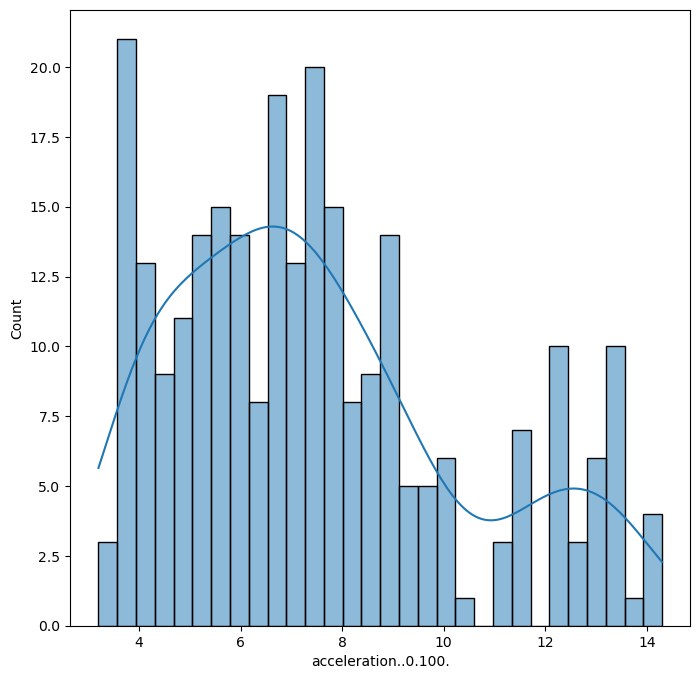

In [15]:
for col in cols:
    plt.figure(figsize=(8,8))
    sns.histplot(df_clean[col],bins=30,kde=True)

## model

In [16]:
from sklearn.model_selection import train_test_split


In [17]:
df_clean.columns

Index(['Battery', 'Efficiency', 'Fast_charge', 'Price.DE.', 'Range',
       'Top_speed', 'acceleration..0.100.'],
      dtype='object')

In [18]:
X = df_clean.drop(columns=['Price.DE.','acceleration..0.100.'], axis=1)
y = df_clean['Price.DE.']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression


In [21]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [22]:
y_pred = model.predict(X_test)


In [23]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test,y_pred)
r2
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - ((1- r2) * (n-1) / (n - p - 1))
adjusted_r2

0.6387165724660868

In [24]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]  # ensures coefficients are positive
}

In [25]:
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='r2',       # can use 'neg_mean_squared_error', etc.
    cv=5,               # 5-fold cross validation
    n_jobs=-1,          # use all CPU cores
    verbose=2           # optional: shows progress
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-1,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='r2', verbose=2)

In [26]:
print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)


Best Parameters: {'copy_X': True, 'fit_intercept': True, 'positive': True}
Best CV Score: 0.7166420276619205


In [27]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Test R² Score:", r2_score(y_test, y_pred))


Test R² Score: 0.6790917057035353


# XGB

In [28]:
df_clean.columns

Index(['Battery', 'Efficiency', 'Fast_charge', 'Price.DE.', 'Range',
       'Top_speed', 'acceleration..0.100.'],
      dtype='object')

In [29]:
X = df_clean.drop(columns=['Price.DE.'], axis=1)
y = df_clean['Price.DE.']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [31]:
from xgboost import XGBRegressor


In [32]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)


In [33]:
param_grid = {
    'n_estimators': [100, 200, 300],        # number of boosting rounds
    'max_depth': [3, 5, 7],                 # tree depth
    'learning_rate': [0.01, 0.05, 0.1],     # step size shrinkage
    'subsample': [0.8, 1.0],                # row sampling
    'colsample_bytree': [0.8, 1.0]          # feature sampling
}


In [34]:
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',      # or 'neg_mean_squared_error'
    cv=3,              # 3-fold cross-validation
    verbose=2,
    n_jobs=-1          # use all cores
)


In [35]:
grid.fit(X_train, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='r2', verbose=2)

In [36]:
print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best CV Score: 0.8042594974728031


In [37]:
best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_test)

print("Test R² Score:", r2_score(y_test, y_pred))


Test R² Score: 0.7326814281004932


## Random forest

In [38]:
from sklearn.ensemble import RandomForestRegressor


In [39]:
rf = RandomForestRegressor(random_state=42)


In [40]:
param_grid = {
    'n_estimators': [100, 200, 300],     # number of trees
    'max_depth': [None, 10, 20, 30],     # depth of each tree
    'min_samples_split': [2, 5, 10],     # min samples to split a node
    'min_samples_leaf': [1, 2, 4],       # min samples per leaf
    'max_features': ['auto', 'sqrt']     # number of features to consider at each split
}


In [41]:
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='r2',      # can also use 'neg_mean_squared_error'
    cv=5,              # 3-fold cross-validation
    n_jobs=-1,         # use all cores
    verbose=2
)


In [42]:
grid.fit(X_train, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\ACER\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
368 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ACER\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ACER\anaconda3\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\ACER\anaconda3\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [43]:
print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score: 0.8200728193771425


In [44]:
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)

print("Test R² Score:", r2_score(y_test, y_pred))


Test R² Score: 0.7162167296683709


In [45]:
rf = RandomForestRegressor(random_state=42,max_depth= None, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100)


In [46]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_features='sqrt', random_state=42)

In [47]:
y_pred=rf.predict(X_test)

In [48]:
r2 = r2_score(y_test,y_pred)
r2



0.7162167296683709

## KNN

In [50]:
from sklearn.neighbors import KNeighborsRegressor
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_test_scaled=scaler.fit_transform(X_test)
X_train_scaled=scaler.fit_transform(X_train)


In [52]:
knn = KNeighborsRegressor()


In [53]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],     # number of nearest neighbors
    'weights': ['uniform', 'distance'],  # uniform = equal weights, distance = closer points more weight
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # distance metrics
    'p': [1, 2]                          # p=1 → Manhattan, p=2 → Euclidean (used with Minkowski)
}


In [54]:
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='r2',     # regression metric
    cv=5,             # 5-fold cross-validation
    n_jobs=-1,        # use all cores
    verbose=2
)


In [58]:
grid.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='r2', verbose=2)

In [59]:
print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)


Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best CV Score: 0.8325543465069316


In [60]:
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test_scaled)

print("Test R² Score:", r2_score(y_test, y_pred))


Test R² Score: 0.4434417367349116


In [66]:
knn = KNeighborsRegressor(metric= 'manhattan', n_neighbors= 3, p= 1, weights= 'distance')

knn.fit(X_train,y_train)


KNeighborsRegressor(metric='manhattan', n_neighbors=3, p=1, weights='distance')

In [67]:
y_knn_predict=knn.predict(X_test


_IncompleteInputError: incomplete input (2829644901.py, line 1)

In [65]:
r2_score(y_test,y_knn_predict)

0.4434417367349116